In [1]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=3e14d12ed31e0b7dcc3ffdb5c62ed564f654178f09a018bc1883f56fc4818896
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from efficientnet_pytorch import EfficientNet

from PIL import Image
import os
import glob
from skimage import io
import copy
import time
import statistics
import cv2

plt.ion()   # interactive mode

**Exploratory Data Analysis**

In [3]:
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}

root_dir = '/kaggle/input/state-farm-distracted-driver-detection/'
train_img_dir = os.path.join(root_dir, 'imgs/train/')
test_img_dir = os.path.join(root_dir, 'imgs/test/')

df_train = pd.read_csv(os.path.join(root_dir, 'driver_imgs_list.csv'))
print("Number of training image details is",df_train.shape[0])

train_img_name = glob.glob(train_img_dir + '*/*.jpg')
print("Number of training images is", len(train_img_name))
test_img_name = glob.glob(test_img_dir + '*.jpg')
print("Number of testing images is", len(test_img_name))

assert(df_train.shape[0]==len(train_img_name))
display(df_train.head())
        
display(df_train.tail())

Number of training image details is 22424
Number of training images is 22424
Number of testing images is 79726


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [ ]:
class_freq = df_train.classname.value_counts()
plt.figure()
plt.title("Class Frequency Analysis")
plt.pie(class_freq, autopct='%1.1f%%', labels= CLASSES.values())
plt.show()

In [ ]:
def showDriver(corr_train, train_img_dir, className):
    plt.figure(figsize=(10,10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        ax.axis('off')
        plt.imshow(io.imread(os.path.join(train_img_dir, className, corr_train.img[corr_train.index[i*100]]))) 
    plt.show()
    

In [ ]:
showDriver(df_train[df_train.classname== 'c7'], train_img_dir, 'c7')

**Data Preprocess**

In [4]:
dataset = datasets.ImageFolder(root= train_img_dir)
class_names = dataset.classes
print(class_names)
print(len(dataset))

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
22424


In [ ]:
display(dataset[18000][0])
print("Class of image is", dataset[18000][1])

In [5]:
TRAIN_RATIO = 0.8

num_train_samples = int(len(dataset)*TRAIN_RATIO)
num_valid_samples = len(dataset) - num_train_samples
train_data, valid_data = random_split(dataset, [num_train_samples, num_valid_samples])
print("Number of training samples before data augmentation is",len(train_data))
print("Number of validation samples is",len(valid_data))

Number of training samples before data augmentation is 17939
Number of validation samples is 4485


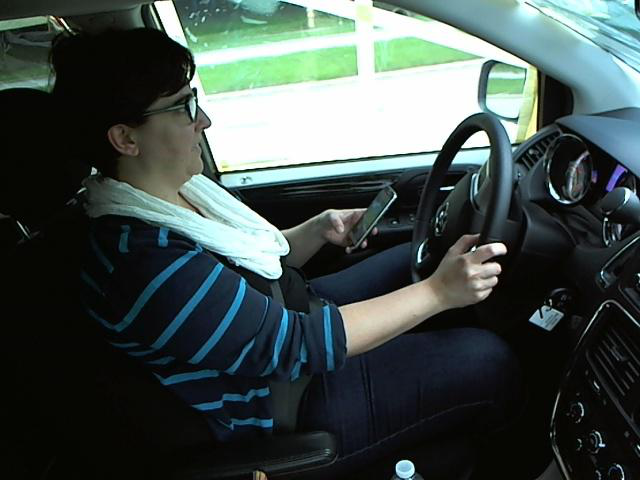

Class of image is 3


In [6]:
display(valid_data[2][0])
print("Class of image is", valid_data[2][1])

In [7]:
# Normalize according to the mean and standard deviation of images in ImageNet Data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
# Applying same transformation yo train and validation???
train_data.dataset.transform = transform
valid_data.dataset.transform = transform

# We’ll use a batch size for the validation set that is twice as large as that for the training set. 
# This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). 
# We take advantage of this to use a larger batch size and compute the loss more quickly.
BATCH_SIZE = 64

# Is it necessary to shuffle here too since we alread shuffle data with randomsplit???
data_loaders = {'train': DataLoader(train_data, batch_size= BATCH_SIZE, shuffle= True), 
                'val': DataLoader(valid_data, batch_size= 2*BATCH_SIZE)}
dataset_sizes = {'train': len(train_data), 'val': len(valid_data)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Length of train_data after transform is", len(train_data))
print("Length of valid_data after transform is", len(valid_data))
print("Length of train dataloader is", len(data_loaders['train']))
print("Length of valid dataloader is", len(data_loaders['val']))
print("Device is", device)

In [8]:
def imshow_transformed_tensorimg(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
imshow_transformed_tensorimg(valid_data[2][0])
print(valid_data[2][1])

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def visualize_model(model, phase, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(60,60))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(type(preds))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow_transformed_tensorimg(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def fit(model, criterion, optimizer, scheduler, phase):   
    running_loss = 0.0
    running_corrects = 0

    # Iterate over all data by mini-batch
    for inputs, labels in data_loaders[phase]:
        # inputs shape is [BATCH_SIZE, C, H, W]
        # labels shape is [BATCH_SIZE, 1] since softmax is not applied yet

        # Move data to corresponding device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward Propagation
        # Track the gradient history if only in train phase
        with torch.set_grad_enabled(phase == 'train'):
            # outputs shape is [BATCH_SIZE, TOTAL_CLASS_NUMBER] since we have 10 nodes in FC layer at the end of CNN.
            outputs = model(inputs)
            # pred shape is [BATCH_SIZE] since we drop 1st dimention of outputs
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward Propagation & Optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # Statics for corresponding mini-batch
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    if phase == 'train':
        scheduler.step()

    epoch_loss = running_loss/dataset_sizes[phase]
    epoch_acc = running_corrects.double()/dataset_sizes[phase]

    print("{} phase => Loss: {:.4f} Acc: {:.4f}".format(
        phase, epoch_loss, epoch_acc))
            
    return epoch_acc

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs = 50):
    start_time = time.time()   
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch + 1, num_epochs))      
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            if phase == 'train':
                # Set model to the training mode
                model.train() 
            else:
                # Set model to the evaluate mode
                model.eval()
            epoch_acc = fit(model, criterion, optimizer, scheduler, phase)
                
            # Save weights of best_acc by deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())                         
        print("-" * 50)
        
    time_elapsed = time.time() - start_time
    print("Training & Validation completes in {:.0f}m {:.0f}s".format(
        time_elapsed//60, time_elapsed % 60))
    print("Best validation accuracy is {:.4f}".format(best_acc))
    
    # Load the best model weights
    model.load_state_dict(best_model_weights)
    return model

In [11]:
#model_en = EfficientNet.from_pretrained('efficientnet-b1')
#num_features = model_en._fc.in_features
model_en = models.resnet18(pretrained=True)
num_features = model_en.fc.in_features

# Size of each output sample is set to 10
model_en._fc = nn.Linear(num_features, 10)

model_en = model_en.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_en = optim.Adam(model_en.parameters(), lr=0.01)

# Learning rate decay by a factor of 0.1 every 10 epochs
log_lr_scheduler = lr_scheduler.StepLR(optimizer_en, step_size=2, gamma = 0.1)
print(f'The model has {count_parameters(model_en):,} trainable parameters')


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



The model has 11,694,642 trainable parameters


In [ ]:
model_en = train(model_en, criterion, optimizer_en, log_lr_scheduler, num_epochs=6)

In [ ]:
# Specify the path 
PATH = "resnet18_64batchSize_1_95valacclimited.pt"

# Save
torch.save(model_en, PATH)

In [12]:
# Load
NEW_PATH = '/kaggle/input/drivermodel/efficientNet-b1_64batchSize.pt'
model = torch.load(NEW_PATH)
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
visualize_model(model, 'val',18)

In [ ]:
def image_loader(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image)
    image_tensor_array = image_tensor.unsqueeze(0)
    #print(image_tensor_array.shape)
    with torch.no_grad():
        data = Variable(image_tensor_array.cuda())
    plt.imshow(io.imread(image_path))
    plt.show()
    out = model(data)
    print(out)
    _, preds = torch.max(out, 1)
    print(preds)
    #print(out.data.max(1, keepdim=True)[1])

image = image_loader('/kaggle/input/ownpics/IMG_20200707_094042.jpg')

**Run Your Own Image**

In [ ]:
transform_own = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomRotation((90,90)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
own_dir = '/kaggle/input/ownv3/'
own_data = datasets.ImageFolder(own_dir, transform_own)
own_dl = DataLoader(own_data, batch_size = 2*BATCH_SIZE)

In [ ]:
imshow_transformed_tensorimg(own_data[3][0])
print(own_data[3][1])

In [ ]:
data_loaders['own'] = own_dl
dataset_sizes['own'] = len(own_data)
own_acc = fit(model, criterion, optimizer_en, log_lr_scheduler, 'own')

In [ ]:
visualize_model(model, 'own', 18)

**Run Your Own Video**

In [61]:
#os.makedirs('/kaggle/working/videoFrames')
os.chdir('/kaggle/working/videoFrames')
vidcap = cv2.VideoCapture('/kaggle/input/videorec/VID_20200708_162814.mp4')
success, image = vidcap.read()
# Seconds counter
count = 0
while success:
    # Set current position of the video file in milliseconds to count*1000
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000)) 
    # Save frame as JPEG file
    cv2.imwrite("frame_%d.jpg" % count, image)           
    success,image = vidcap.read()
    count += 1

In [ ]:
a = torch.tensor([0,2,3,4,5,2,2])
b = a.numpy()
try: 
    value = statistics.mode(b)
    first_index = np.where(b ==value)[0][0]
    print(first_index)
except:
    print(b)

In [70]:
def visualize_videoFrames(model, dl):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(60,60))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            time_window = 5
            for j in range(0, inputs.size()[0], time_window):
                null_preds = preds.cpu().numpy()[j:j+time_window]
                try:
                    freq_pred = statistics.mode(null_preds)
                    first_freq_idx = np.where(null_preds == freq_pred)[0][0]+j
                except:                  
                    continue     
                images_so_far += 1
                ax = plt.subplot(inputs.size()[0]//(3*time_window), 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[first_freq_idx]]))
                imshow_transformed_tensorimg(inputs.cpu().data[first_freq_idx])
        model.train(mode=was_training)

In [62]:
videoFrame_dir = '/kaggle/working/'
videoFrame_data = datasets.ImageFolder(videoFrame_dir, transform)
videoFrame_dl = DataLoader(videoFrame_data, batch_size = len(videoFrame_data))

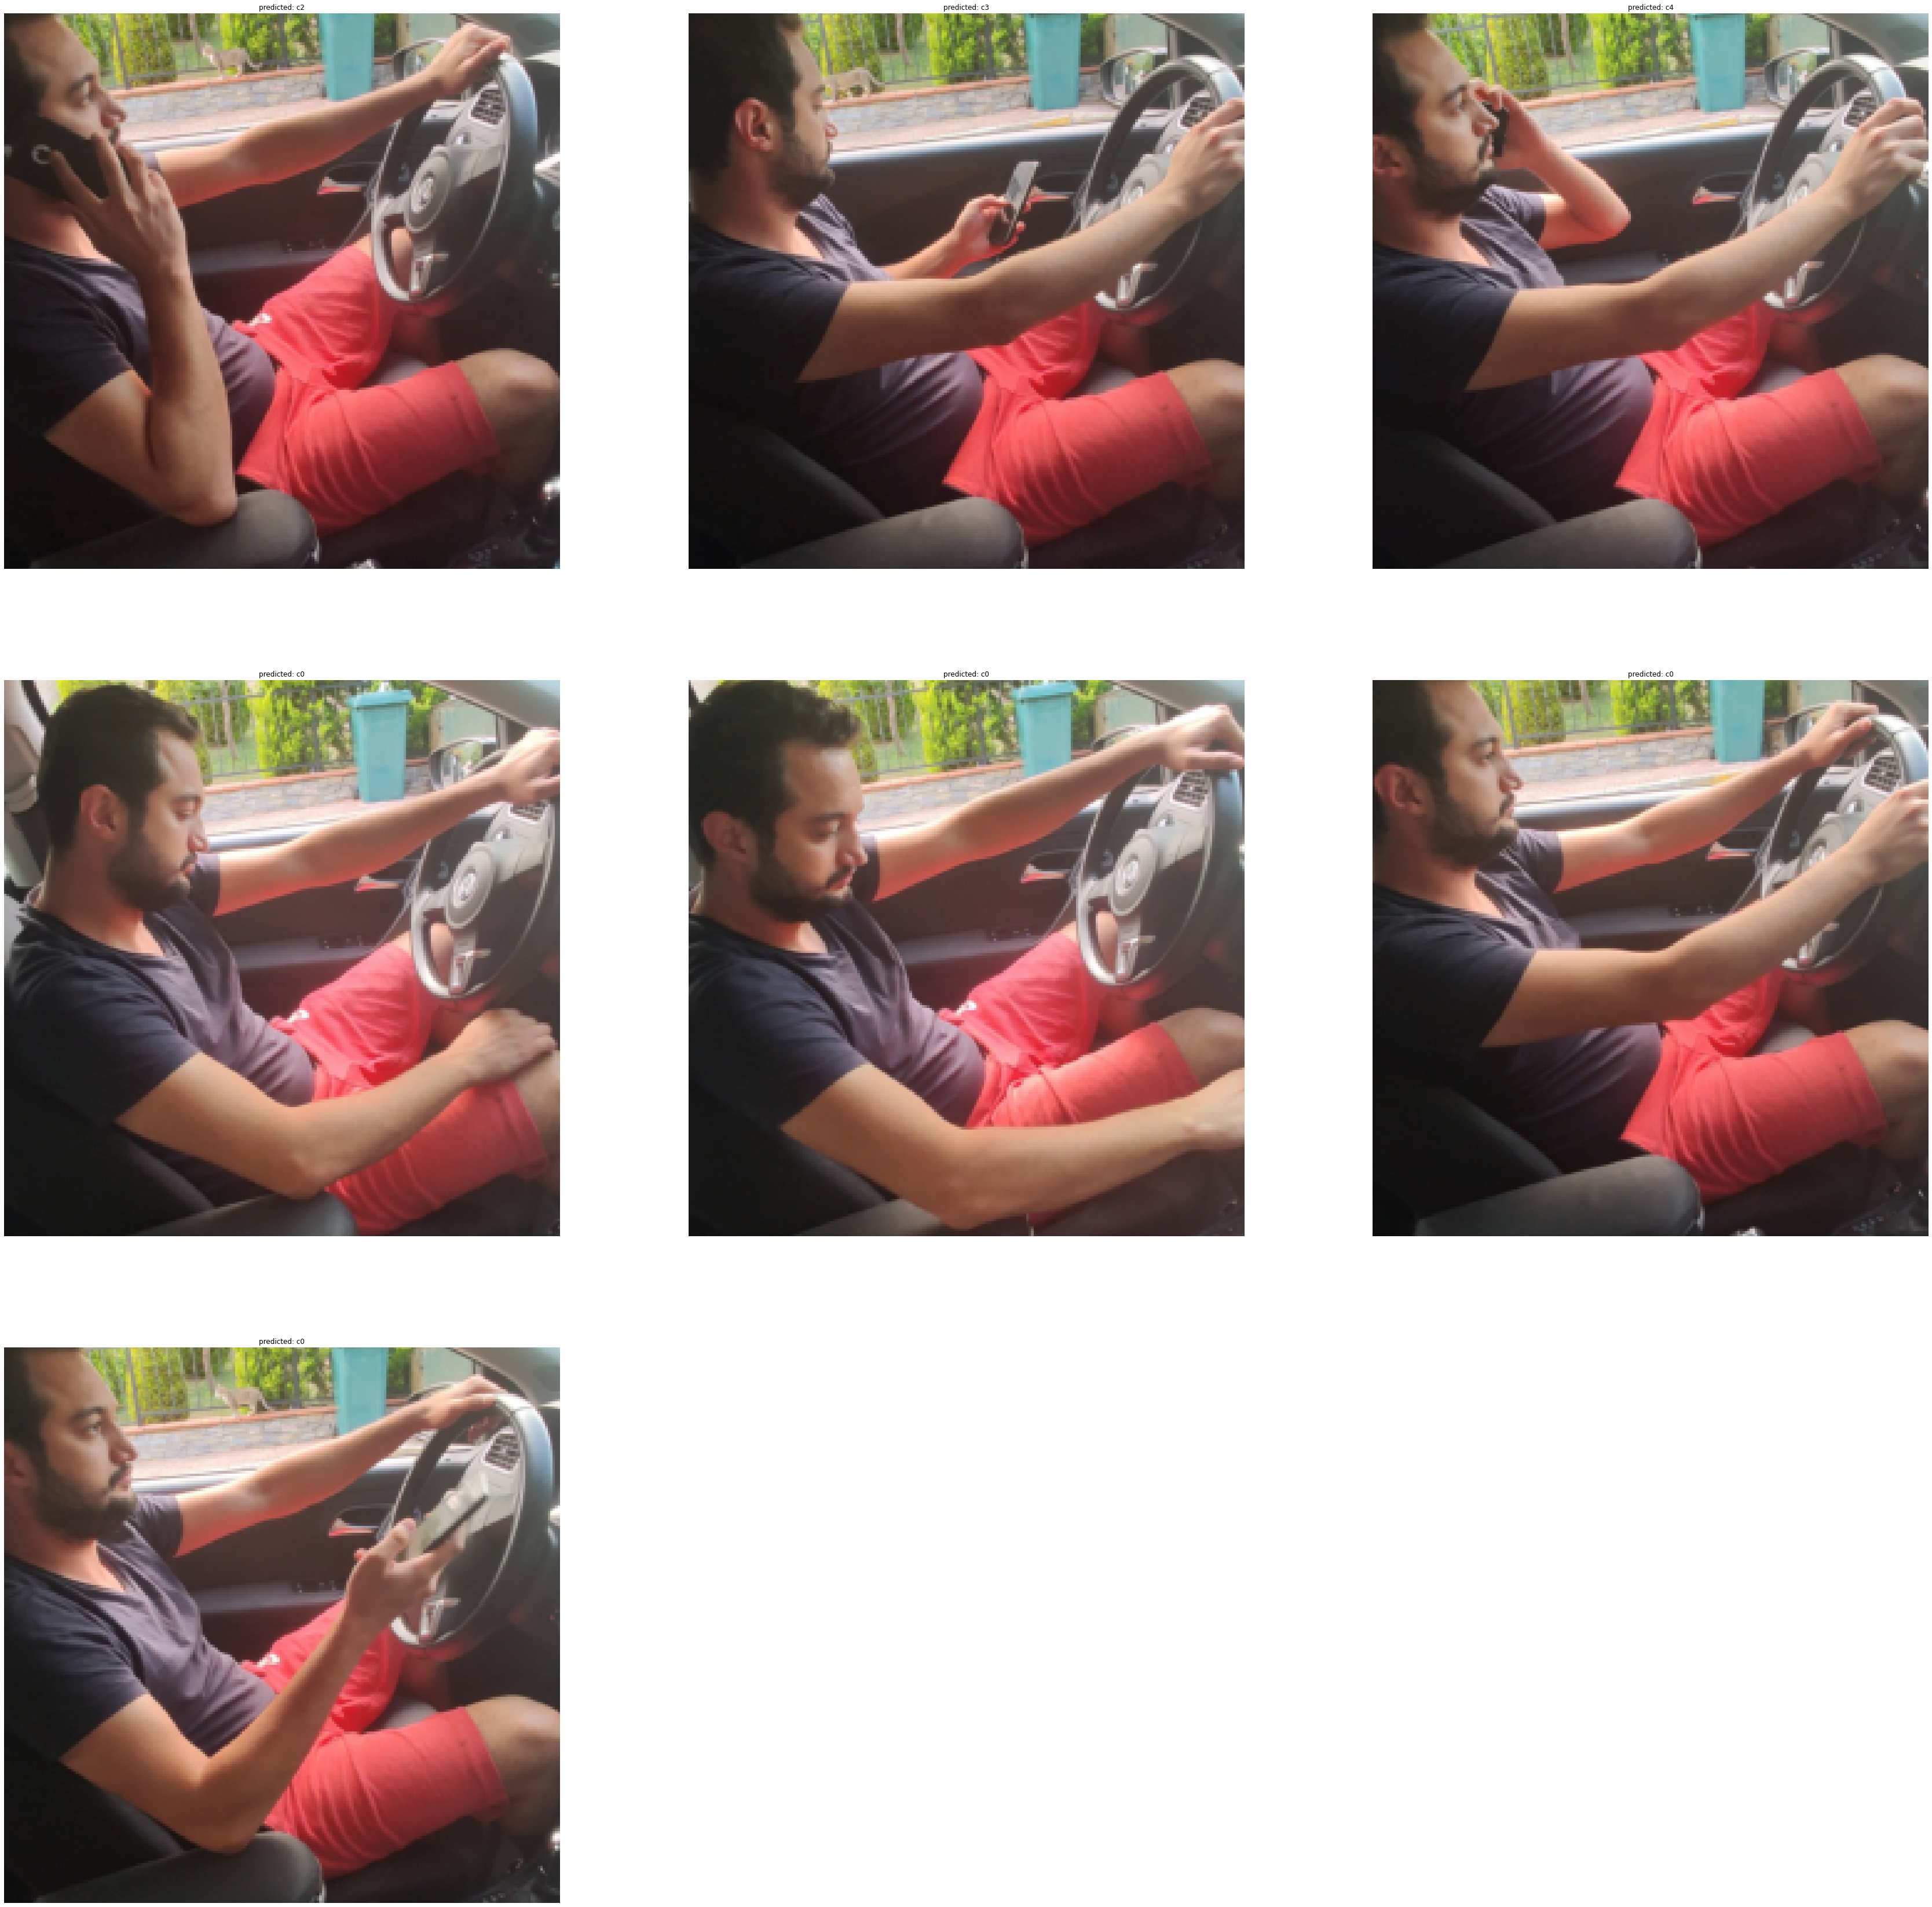

In [71]:
visualize_videoFrames(model, videoFrame_dl)